<a href="https://colab.research.google.com/github/anilturker/signatureVerification/blob/main/offline_signature_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Offline Signature Verification**




In [2]:
# Import Libraries
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, Dropout, Lambda, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

In [3]:
# Dowload and extract CEFAR signature dataset

URL = "http://www.cedar.buffalo.edu/NIJ/data/signatures.rar"
filename = "signatures.rar"
dataset_directory ="signatures"

if os.path.exists(dataset_directory) == False: 
  if os.path.exists(filename) == False:
    print("Dowloading dataset")
    !wget --output-document=$filename $URL

  print("Extracting rar file")
  !mkdir -p signatureDataset
  !unrar x -y $filename $dataset_directory


Dowloading dataset
--2021-02-27 11:23:11--  http://www.cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving www.cedar.buffalo.edu (www.cedar.buffalo.edu)... 128.205.33.100
Connecting to www.cedar.buffalo.edu (www.cedar.buffalo.edu)|128.205.33.100|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cedar.buffalo.edu/NIJ/data/signatures.rar [following]
--2021-02-27 11:23:11--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.33.100
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.33.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253587033 (242M) [text/plain]
Saving to: ‘signatures.rar’

signatures.rar      100%[===================>] 241.84M  41.1MB/s    in 7.2s    

2021-02-27 11:23:19 (33.4 MB/s) - ‘signatures.rar’ saved [253587033/253587033]

Extracting rar file

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting 

In [4]:
# Create list that consist filename of genuine signatures
# Assume all signature is genuine signature

sign_list = []
sign_labels = []

sign_path = os.path.join(dataset_directory, "full_org")
for sign in sorted(os.listdir(sign_path)):
  if sign.find("png") > 0:
    sign_list.append(sign)
    sign_labels.append(int(sign.split("_")[1]))

# Convert list to numpy array
sign_array = np.array(sign_list)
sign_label_array = np.array(sign_labels)

num_writers = 55
total_signature_for_each_writer = 24
total_size_signatures = sign_label_array.shape[0]

In [5]:
# Show the full path of the signatures
print("Filename is : ", sign_array[0])
print("Label is : ", sign_label_array[0])

# Size of signature images
print("Total size of the signatures is : ", total_size_signatures)

# Shape of a signature image
im = cv2.imread(os.path.join(sign_path, sign_array[0]))
print("Shape is : ", im.shape)


Filename is :  original_10_1.png
Label is :  10
Total size of the signatures is :  1320
Shape is :  (385, 534, 3)


In [6]:
# Visualize the signatures
def visualize_signature(isWriterSame = False, isSignatureSame = False):
  img_size = (224, 224)
  w1 = np.random.randint(num_writers - 1) + 1
  w2 = np.random.randint(num_writers - 1) + 1
  s1 = np.random.randint(total_signature_for_each_writer - 1) + 1
  s2 = np.random.randint(total_signature_for_each_writer - 1) + 1
  
  if isWriterSame == True:
    w2 = w1
  if isSignatureSame == True:
    s2 = s1

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
  im1_name = "/original_" + str(w1) + "_" + str(s1) + ".png"
  im2_name = "/original_" + str(w2) + "_" + str(s2) + ".png"
  orig_im_1 = cv2.resize(cv2.imread(sign_path + im1_name), img_size)
  orig_im_2 = cv2.resize(cv2.imread(sign_path + im2_name), img_size)
  ax1.imshow(orig_im_1, cmap = "gray")
  ax2.imshow(orig_im_2, cmap = "gray")
  ax1.set_title("Signature 1")
  ax2.set_title("Signature 2")
  ax1.axis('off')
  ax2.axis('off')
    

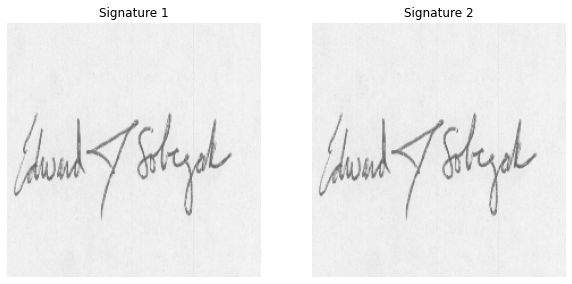

In [14]:
visualize_signature(isWriterSame = True, isSignatureSame = True)

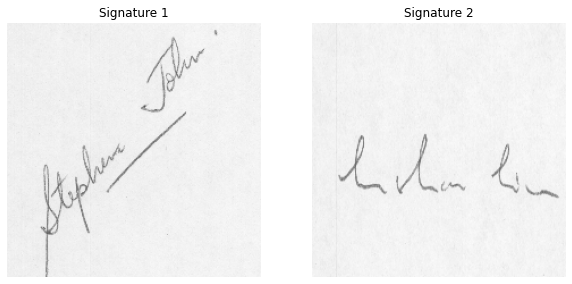

In [15]:
visualize_signature()

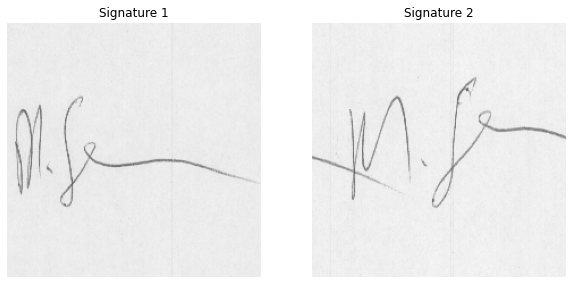

In [16]:
visualize_signature(isWriterSame = True)

In [7]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = [] 
    n = min([len(digit_indices[d]) for d in range(num_writers)]) - 1
    n = min([len(digit_indices[d]) for d in range(num_writers)]) - 1

    for d in range(num_writers):
        for i in range(n):
            for j in range(2):
              z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
              pairs += [[x[z1], x[z2]]]
              inc = random.randrange(1, num_writers + 1)
              dn = (d + inc) % num_writers
              z1, z2 = digit_indices[d][i], digit_indices[dn][i]
              pairs += [[x[z1], x[z2]]]
              labels += [1, 0]

    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(1, num_writers + 1)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')

    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()



In [8]:
# create pairs 
pairs, y = create_pairs_on_set(sign_array, sign_label_array)

# preprocessing 
pairs_image = []
img_size = (224, 224, 1)
for i in range(pairs.shape[0]):

  # resize images
  im1 = cv2.resize(cv2.imread(os.path.join(sign_path, pairs[i][0]), cv2.IMREAD_GRAYSCALE), img_size[0:2])
  im2 = cv2.resize(cv2.imread(os.path.join(sign_path, pairs[i][1]), cv2.IMREAD_GRAYSCALE), img_size[0:2])

  # normalize
  im1 = im1.astype('float32')
  im2 = im2.astype('float32')

  # normalize values
  im1 = im1 / 255.0
  im2 = im2 / 255.0

  pairs_image += [[im1, im2]]

pairs_image_array = np.array(pairs_image) 

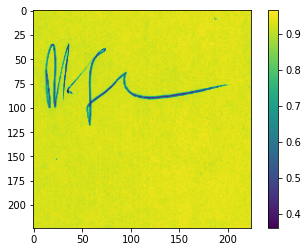

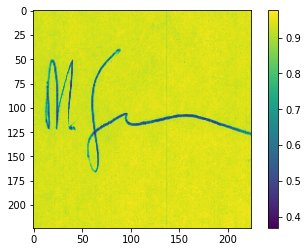

1.0


In [9]:
# array index
this_pair = random.randrange(len(pairs)-1)

# show images at this index
show_image(pairs_image_array[this_pair][0])
show_image(pairs_image_array[this_pair][1])

# print the label for this pair
print(y[this_pair])

In [10]:
# shuffle data
shuffled_x, shuffled_y = shuffle(pairs_image_array, y)

# split data as train and test
train_ratio = 0.8;
train_size = int(train_ratio * shuffled_x.shape[0])

train_x = shuffled_x[:train_size]
train_y = shuffled_y[:train_size]

test_x = shuffled_x[train_size:]
test_y = shuffled_y[train_size:]

In [11]:
# Lengh of train and test data
print("Size of train image pairs is : ", train_x.shape[0])
print("Size of test image pairs is : ", test_x.shape[0])

Size of train image pairs is :  4048
Size of test image pairs is :  1012


## Build the Model


In [12]:
def initialize_base_network():
  input = Input(shape=img_size, name="base_input2")
  x = Conv2D(128, kernel_size=(7,7), activation="relu", name='conv1_1', strides=4)(input)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

  x = Conv2D(256, kernel_size=(5,5), activation="relu", name='conv2_1', strides=1)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

  x = Conv2D(512, kernel_size=(3,3), activation="relu", name='conv3_1', strides=1)(x)
  x = Conv2D(1024, kernel_size=(3,3), activation="relu", name='conv5_1', strides=1)(x)
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

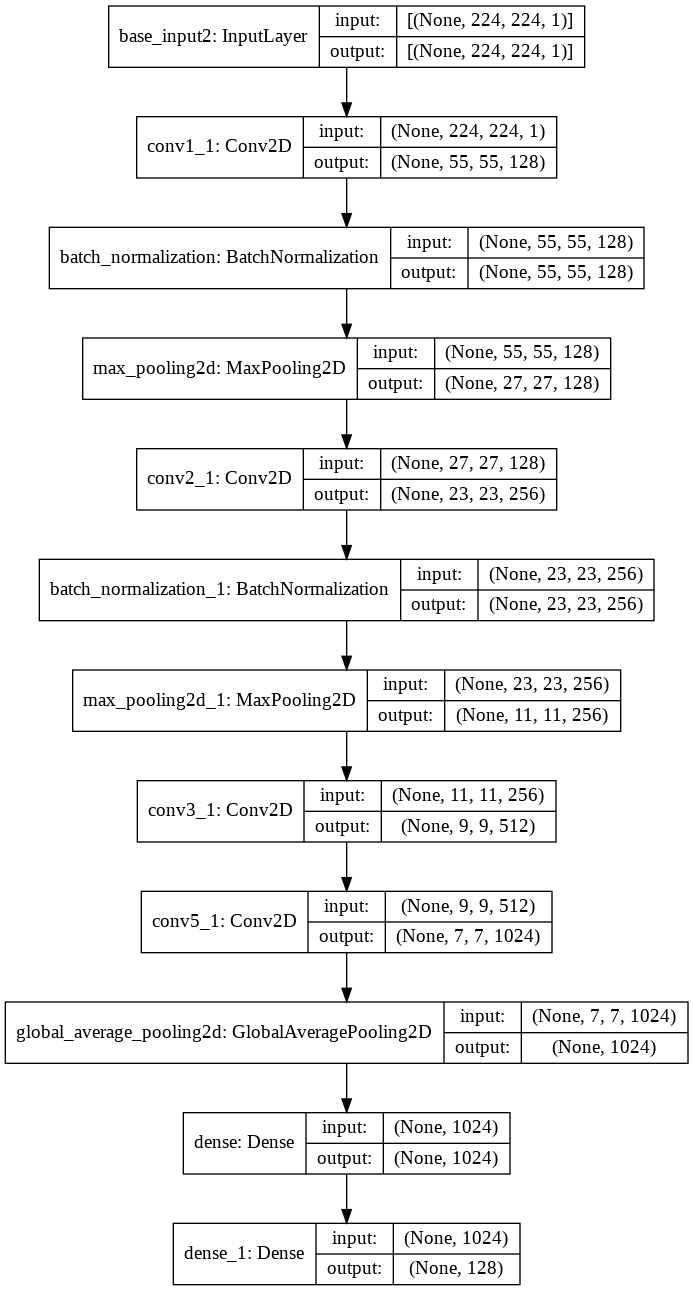

In [13]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

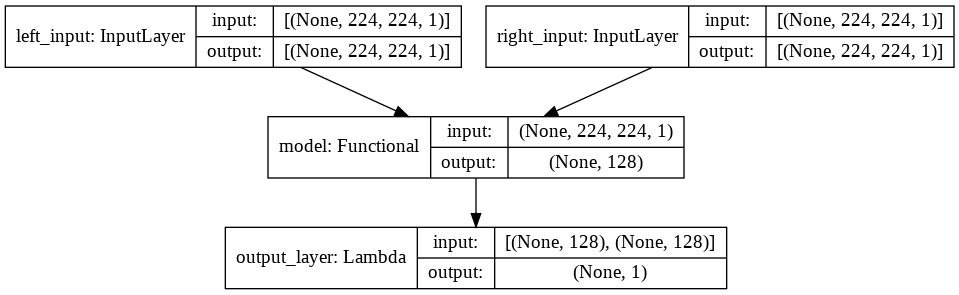

In [14]:
# create the left input and point to the base network
input_a = Input(shape=img_size, name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=img_size, name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [15]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [17]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([train_x[:,0], train_x[:,1]], train_y, epochs=20, batch_size=128, validation_data=([test_x[:,0], test_x[:,1]], test_y))

Epoch 1/20
32/32 [==============================] - 10s 270ms/step - loss: 0.5033 - val_loss: 0.4859
Epoch 2/20
32/32 [==============================] - 6s 193ms/step - loss: 0.5001 - val_loss: 0.4859
Epoch 3/20
32/32 [==============================] - 6s 192ms/step - loss: 0.5014 - val_loss: 0.4859
Epoch 4/20
32/32 [==============================] - 6s 192ms/step - loss: 0.5110 - val_loss: 0.4859
Epoch 5/20
32/32 [==============================] - 6s 192ms/step - loss: 0.5047 - val_loss: 0.4859
Epoch 6/20
32/32 [==============================] - 6s 193ms/step - loss: 0.5053 - val_loss: 0.4859
Epoch 7/20
32/32 [==============================] - 6s 193ms/step - loss: 0.5114 - val_loss: 0.4859
Epoch 8/20
32/32 [==============================] - 6s 194ms/step - loss: 0.5030 - val_loss: 0.4859
Epoch 9/20
32/32 [==============================] - 6s 194ms/step - loss: 0.5011 - val_loss: 0.4859
Epoch 10/20
32/32 [==============================] - 6s 196ms/step - loss: 0.4945 - val_loss: 0.485

In [18]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
loss = model.evaluate(x=[test_x[:,0],test_x[:,1]], y=test_y)

y_pred_train = model.predict([train_x[:,0], train_x[:,1]])
train_accuracy = compute_accuracy(train_y, y_pred_train)

y_pred_test = model.predict([test_x[:,0], test_x[:,1]])
test_accuracy = compute_accuracy(test_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

NameError: ignored

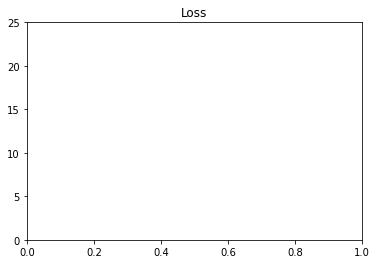

In [26]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=25)

In [31]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

def resize_images(left, right):
  resized_left_images = np.zeros(shape=(left.shape[0], 128, 128)) 
  resized_right_images = np.zeros(shape=(right.shape[0], 128, 128))
  for i in range(left.shape[0]):
    resized_left_images[i] = cv2.resize(left[i], (128, 128))
    resized_right_images[i] = cv2.resize(right[i], (128, 128))
  
  return resized_left_images, resized_right_images


# utility to display a row of digits with their predictions
def display_images(left_image, right_image, predictions, labels, title, n):
    left, right = resize_images(left_image, right_image)
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 128, 128])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [128, 128*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 128, 128])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [128, 128*n])
    plt.imshow(right)


(2024,)


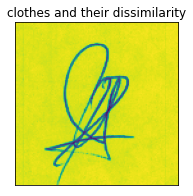

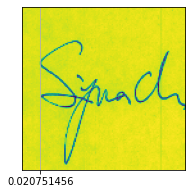

In [42]:
y_pred_train = np.squeeze(y_pred_train)
print(y_pred_train.shape)
indexes = np.random.choice(len(y_pred_train), size=1)
display_images(train_x[:, 0][indexes], train_x[:, 1][indexes], y_pred_train[indexes], train_y[indexes], "clothes and their dissimilarity", 1)